In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob
import cartopy.crs as ccrs
import cartopy

In [ ]:
#get list of files for several days.  don't save 'rt' files
fname = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2020/001/20200101013834-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r40549-v02.0-fv01.0.nc'
files = glob('z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/001/*.nc')
for idy in range(2,8):
    files2 = glob('z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/'+str(idy).zfill(3)+'/*.nc')
    for f in files2:
        if '_v08_' in f:
            files.append(f)
adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
print(len(files))
#files

In [ ]:
#order files and calculate revisit time for different swath widths
#for dw in range(31,51,2):
#for dw in range(31,51,2):
for dw in range(32,38,6):
    ordered_files = []
    for ifile in range(len(files)):
        adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
        fname = adir + files[ifile][2:]
        fname=fname.replace('\\','/')
        ds = xr.open_dataset(fname)
        ds.close()
        ordered_files.append(ds.time.data)
    iarg = np.argsort(ordered_files,axis=0)

    da2 = xr.DataArray(np.zeros((1800,3600)),name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3 = xr.DataArray(np.ones((1800,3600))*99999999,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    dt = -99
    for ifile in iarg:
        adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
        tem_file = files[ifile[0]]
        #print(tem_file)
        fname = adir + tem_file[2:]
        fname=fname.replace('\\','/')
        ds = xr.open_dataset(fname)
        ds = ds.isel(ni=slice(121-dw,121+dw))
        #print(ds.time.data)
        if dt==-99:
            start_time = ds.time
            dt = (ds.time[0] - ds.time[0])/np.timedelta64(1,'s')
        else:
            dt = (ds.time[0] - start_time)/np.timedelta64(1,'s')
        print(ifile,dt.data)
        x = ds['lon'].fillna(-89).data 
        y = ds['lat'].fillna(-89).data 
        z = ds['sst_dtime'].data + int(dt)
        lons,lats,data = x,y,z 
        swath_def = SwathDefinition(lons, lats)
        grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
        grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

        # Since we have the lon and lat values for the area, we define a grid instead of an area:
        # https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
        grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

        result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
        da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
        daeq = da.sel(lat=0,method='nearest')
        swidth = len(daeq.where(daeq>0,drop=True))*10/2
        dif = da - da2
        dif = np.where(da2>0,dif,999999)
        da3 = np.where(dif<da3,dif,da3)
        da2 = np.where(da>da2,da,da2)
        da2 = xr.DataArray(da2,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3 = xr.DataArray(da3,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3.to_netcdf('C:/Users/gentemann/Google Drive/f_drive/docs/proposals/nasa/EVM/JPL_EVM3/data/full_width'+str(swidth)+'.nc')

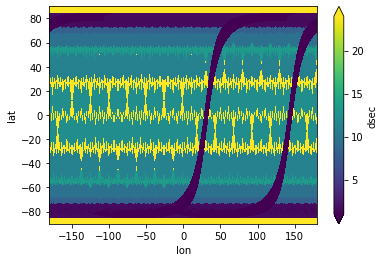

In [5]:
swidth = 640.0
ds = xr.open_dataset('C:/Users/gentemann/Google Drive/f_drive/docs/proposals/nasa/EVM/JPL_EVM3/data/full_width'+str(swidth)+'.nc')
(ds.dsec/60/60).plot(vmin=1,vmax=24)

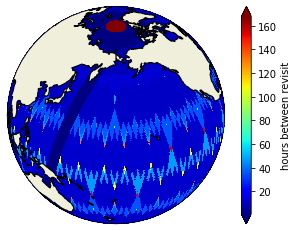

In [9]:
ax = plt.axes(projection=ccrs.Orthographic(180, 1))
(ds.dsec/60/60).plot(ax=ax, transform=ccrs.PlateCarree(),cmap='jet',vmin=1,vmax=24*7,cbar_kwargs={'label': 'hours between revisit'})
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
#ax.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())  #data projection

In [ ]:
#test plot
adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
fname = adir + files[0][2:]
fname=fname.replace('\\','/')
fname
ds = xr.open_dataset(fname)
gattrs = {"units": "seconds since "+str(ds.time[0].data)}
ds2 = ds
ds2.sst_dtime.attrs = gattrs
ds2 = xr.decode_cf(ds2)
x = ds.lon.data
y = ds.lat.data
z = ds.dt_analysis.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')


In [ ]:
#test swath width
dw=38
ds = xr.open_dataset(fname)
ds = ds.isel(ni=slice(121-dw,121+dw))
#print(ds.time.data)
if dt==-99:
    start_time = ds.time
    dt = (ds.time[0] - ds.time[0])/np.timedelta64(1,'s')
else:
    dt = (ds.time[0] - start_time)/np.timedelta64(1,'s')
#print(ifile,dt.data)
x = ds['lon'].fillna(-89).data 
y = ds['lat'].fillna(-89).data 
z = ds['sst_dtime'].data + int(dt)
lons,lats,data = x,y,z 
swath_def = SwathDefinition(lons, lats)
grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

# Since we have the lon and lat values for the area, we define a grid instead of an area:
# https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
daeq = da.sel(lat=0,method='nearest')
swidth = len(daeq.where(daeq>0,drop=True))*10/2
print(swidth)

In [ ]:
#order files and calculate revisit time for different swath widths
#for dw in range(31,51,2):
#for dw in range(31,51,2):
ordered_files = []
for ifile in range(len(files)):
    adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
    fname = adir + files[ifile][2:]
    fname=fname.replace('\\','/')
    ds = xr.open_dataset(fname)
    ds.close()
    ordered_files.append(ds.time.data)
iarg = np.argsort(ordered_files,axis=0)
for dw in range(32,39,6):
    da2 = xr.DataArray(np.zeros((1800,3600)),name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3 = xr.DataArray(np.ones((1800,3600))*99999999,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    dt = -99
    for cnt,ifile in enumerate(iarg):
        adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
        tem_file = files[ifile[0]]
        #print(tem_file)
        fname = adir + tem_file[2:]
        fname=fname.replace('\\','/')
        ds = xr.open_dataset(fname)
        ds = ds.isel(ni=slice(121-dw,121+dw))
        #print(ds.time.data)
        if dt==-99:
            start_time = ds.time
            dt = (ds.time[0] - ds.time[0])/np.timedelta64(1,'s')
        else:
            dt = (ds.time[0] - start_time)/np.timedelta64(1,'s')
        print(ifile,dt.data)
        x = ds['lon'].fillna(-89).data 
        y = ds['lat'].fillna(-89).data 
        z = ds['sst_dtime'].data + int(dt)
        lons,lats,data = x,y,z 
        swath_def = SwathDefinition(lons, lats)
        grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
        grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

        # Since we have the lon and lat values for the area, we define a grid instead of an area:
        # https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
        grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

        result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
        da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
        daeq = da.sel(lat=0,method='nearest')
        swidth = len(daeq.where(daeq>0,drop=True))*10/2
        dif = da - da2
        dif = np.where(da2>0,dif,999999)
        da3 = np.where(dif<da3,dif,da3)
        da2 = np.where(da>da2,da,da2)
        da2 = xr.DataArray(da2,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3 = xr.DataArray(da3,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3.to_netcdf('C:/Users/gentemann/Google Drive/f_drive/docs/proposals/nasa/EVM/JPL_EVM3/data/full_width'+str(swidth)+'.nc')

In [ ]:
(da3/60/60/24).plot()

In [ ]:
da2 = xr.DataArray(np.zeros((1800,3600)),name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))

for ifile in range(2):
    adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
    fname = adir + files[ifile][2:]
    fname=fname.replace('\\','/')
    ds = xr.open_dataset(fname)


gattrs = {"units": "seconds since "+str(ds.time[0].data)}
ds.sst_dtime.attrs = gattrs
ds2 = xr.decode_cf(ds)
x = ds['lon'].fillna(-89).data 
y = ds['lat'].fillna(-89).data 
z = ds['sst_dtime'].data 
lons,lats,data = x,y,z 
swath_def = SwathDefinition(lons, lats)
grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

# Since we have the lon and lat values for the area, we define a grid instead of an area:
# https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))

da2 = np.where(da>da2,da,da2)
da2 = xr.DataArray(da2,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))


In [ ]:
da2.plot()